# Implementation of Linear Regression

**Author:** Diego Antonio García Padilla (A01710777)

---

For the submission of Module 2, I will implement a linear regression model using the [Boston House Price Dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data). The dataset contains the following features:

1) `CRIM`: per capita crime rate by town.
2) `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
3) `INDUS`: proportion of non-retail business acres per town.
4) `CHAS`: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
5) `NOX`: nitric oxides concentration (parts per 10 million) [parts/10M].
6) `RM`: average number of rooms per dwelling.
7) `AGE`: proportion of owner-occupied units built prior to 1940.
8) `DIS`: weighted distances to five Boston employment centres.
9) `RAD`: index of accessibility to radial highways.
10) `TAX`: full-value property-tax rate per \$10,000 [\$$10k].
11) `PTRATIO`: pupil-teacher ratio by town.
12) `B`: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
13) `LSTAT`: % lower status of the population.

And the following output feature:

14) **MEDV**: Median value of owner-occupied homes in \$1000's [k$$].

## Enviroment setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from typing import Tuple

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
np.random.seed(42)

## ETL Process

### Extract

In [3]:
# Load data
df = pd.read_csv("boston.csv")

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Transform

First, I will check the data types of the features to ensure they are appropriate for the analysis.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


Everything seems to be in order with the data types, except for CHAS, which is currently of type `int64`. Since this is a categorical variable and I want to do a linear regression analysis, I will remove it from the dataset.


In [5]:
df.drop(columns=["CHAS"], inplace=True)

Then, I will drop missing values from the dataset to ensure a complete case analysis.

In [6]:
# Drop missing values if any
df = df.dropna()

#### Correlation and $p_{values}$

To know which features are most important for predicting the target variable, I can calculate its correlation and p-values, and then visualize the correlations using a heatmap.

If the correlation is high (close to 1 or -1), it indicates a strong relationship between the feature and the target variable. If the correlation is low (close to 0), it suggests a weak relationship. 

The p-value helps to determine the statistical significance of the correlation. A low p-value (typically < 0.05) indicates that the correlation is statistically significant, while a high p-value suggests that the correlation may be due to chance.


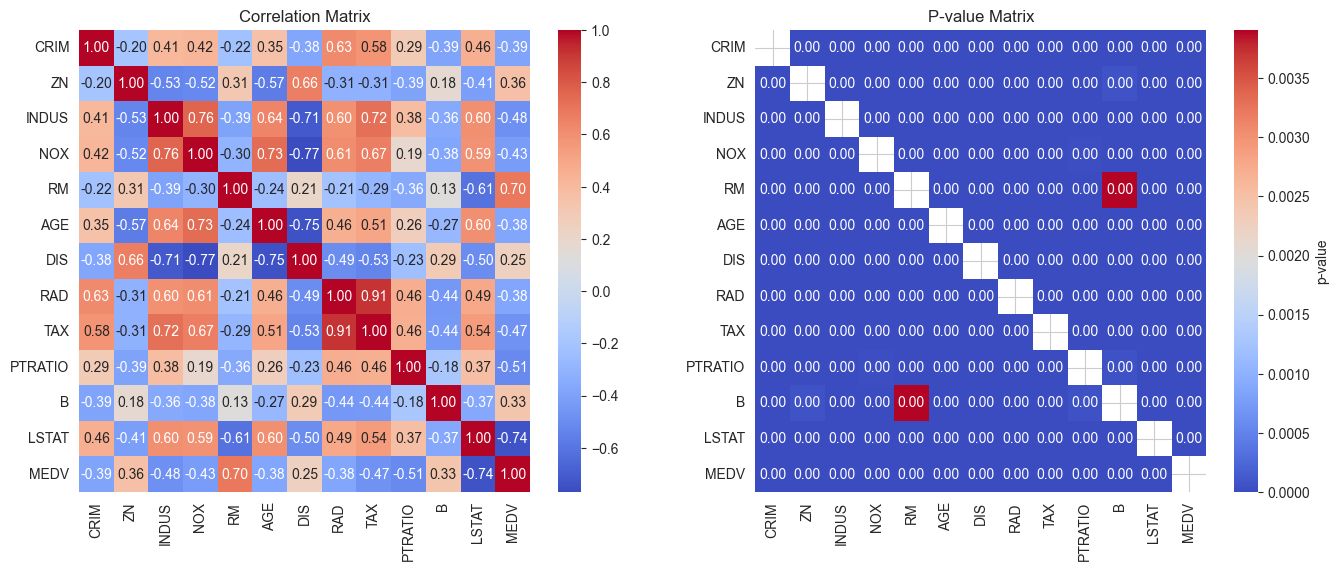

In [7]:
def p_value_matrix(df):
    p_values = pd.DataFrame(columns=df.columns, index=df.columns)
    for col in df.columns:
        for target in df.columns:
            if col != target:
                _, p_value = stats.pearsonr(df[col], df[target])
                p_values.loc[col, target] = p_value
    return p_values

def plot_correlation_and_p_values(df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Correlation Matrix")

    sns.heatmap(p_value_matrix(df).astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-value'}, ax=axes[1])
    axes[1].set_title("P-value Matrix")

plot_correlation_and_p_values(df)

With p-values that small, I will use correlation coefficients to identify the most important features for predicting the target variable.

If the absolute value of the correlation coefficient is greater than 0.4, I will consider the feature important for prediction.


In [8]:
# Drop irrelevant features
df.drop(columns=["CRIM", "ZN", "AGE", "DIS","RAD", "B"], inplace=True)

df.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,MEDV
0,2.31,0.538,6.575,296.0,15.3,4.98,24.0
1,7.07,0.469,6.421,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,222.0,18.7,5.33,36.2


I still have to check if there is any collinearity between the features. I can do this by looking at the correlation matrix and identifying any pairs of features with a high correlation coefficient (e.g., above 0.8 or below -0.8).


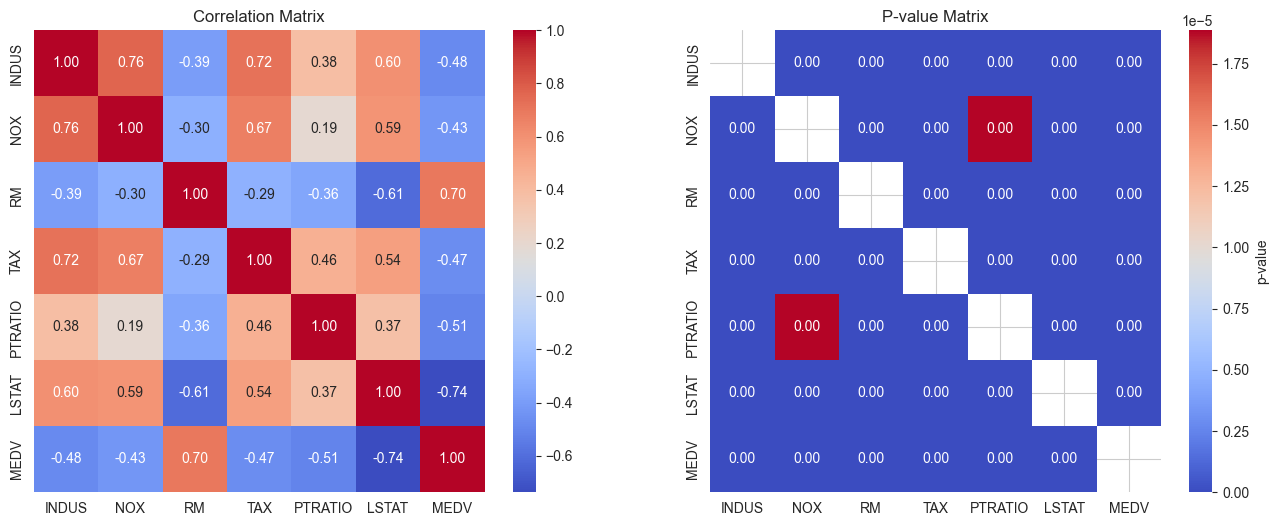

In [9]:
plot_correlation_and_p_values(df)

I'll drop INDUS and TAX because it has a very strong correlation with NOX.


In [10]:
df.drop(columns=["INDUS", "TAX"], inplace=True)

#### Data splitting


Now, I will standardize the features to ensure they are on the same scale. This is important for linear regression, as it can be sensitive to the scale of the input features.

But first, to avoid data leakage, we need to split the data into training and testing sets before applying any transformations.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#### Outlier removal

Now we can visualize the distribution of the target variable in the training set.

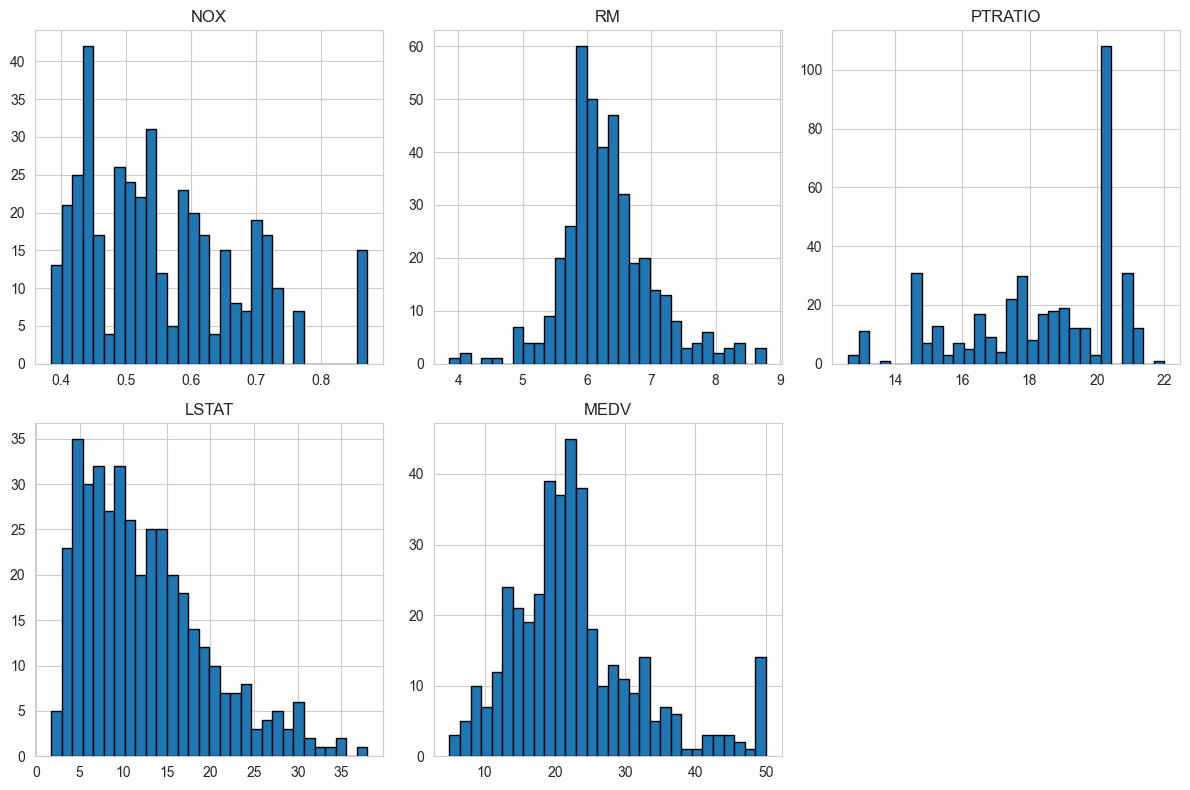

In [12]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

As we can see, there are a lot of outliers in the training set. 

- LSTAT is skewed to the right, with a long tail. I will use log transformation.
- NOX is also skewed. I will use winsorization to cap the values at the 5th and 95th percentiles.

In [13]:
# Log-transformation of LSTAT
print(f"Bias LSTAT before: {stats.skew(df_train['LSTAT']):.2f}")

df_train['LSTAT'] = np.log1p(df_train['LSTAT'])
df_test['LSTAT'] = np.log1p(df_test['LSTAT'])

print(f"Bias LSTAT after: {stats.skew(df_train['LSTAT']):.2f}")

Bias LSTAT before: 0.93
Bias LSTAT after: -0.15


In [14]:
# Winsorize NOX
print(f"Bias NOX before: {stats.skew(df_train['NOX']):.2f}")

lower_bound = df_train["NOX"].quantile(0.05)
upper_bound = df_train["NOX"].quantile(0.95)

df_train["NOX"] = df_train["NOX"].clip(lower=lower_bound, upper=upper_bound)
df_test["NOX"] = df_test["NOX"].clip(lower=lower_bound, upper=upper_bound)

print(f"Bias NOX after: {stats.skew(df_train['NOX']):.2f}")

Bias NOX before: 0.75
Bias NOX after: 0.45


In [15]:
# Reset index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Extract X and y
X_train = df_train.drop('MEDV', axis=1)
y_train = df_train['MEDV']
X_test = df_test.drop('MEDV', axis=1)
y_test = df_test['MEDV']

# Rebuild dataframes
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

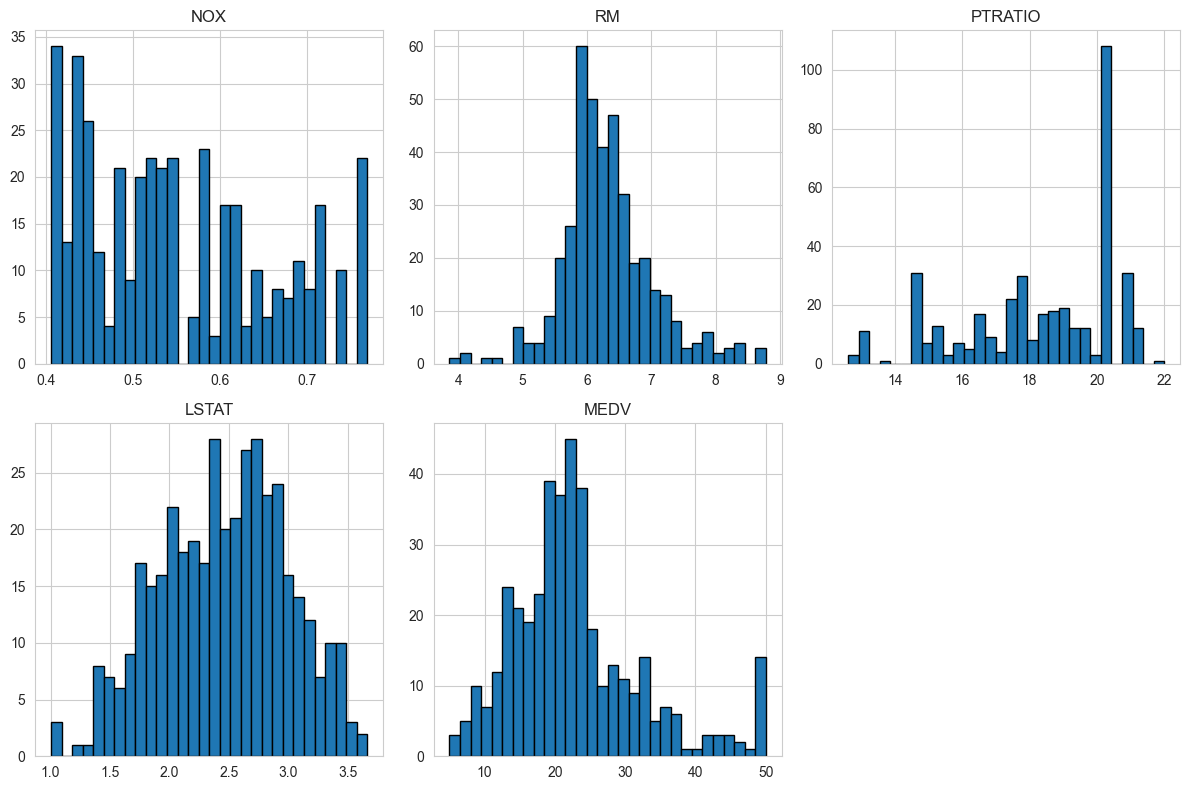

In [16]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

#### Standarization (z-score)

In [17]:
scaler_X = StandardScaler()

X_train = pd.DataFrame(scaler_X.fit_transform(X_train))
X_test = pd.DataFrame(scaler_X.transform(X_test))

df_train = pd.concat([X_train, y_train], axis=1)
df_train.columns = df.columns
df_test = pd.concat([X_test, y_test], axis=1)
df_test.columns = df.columns

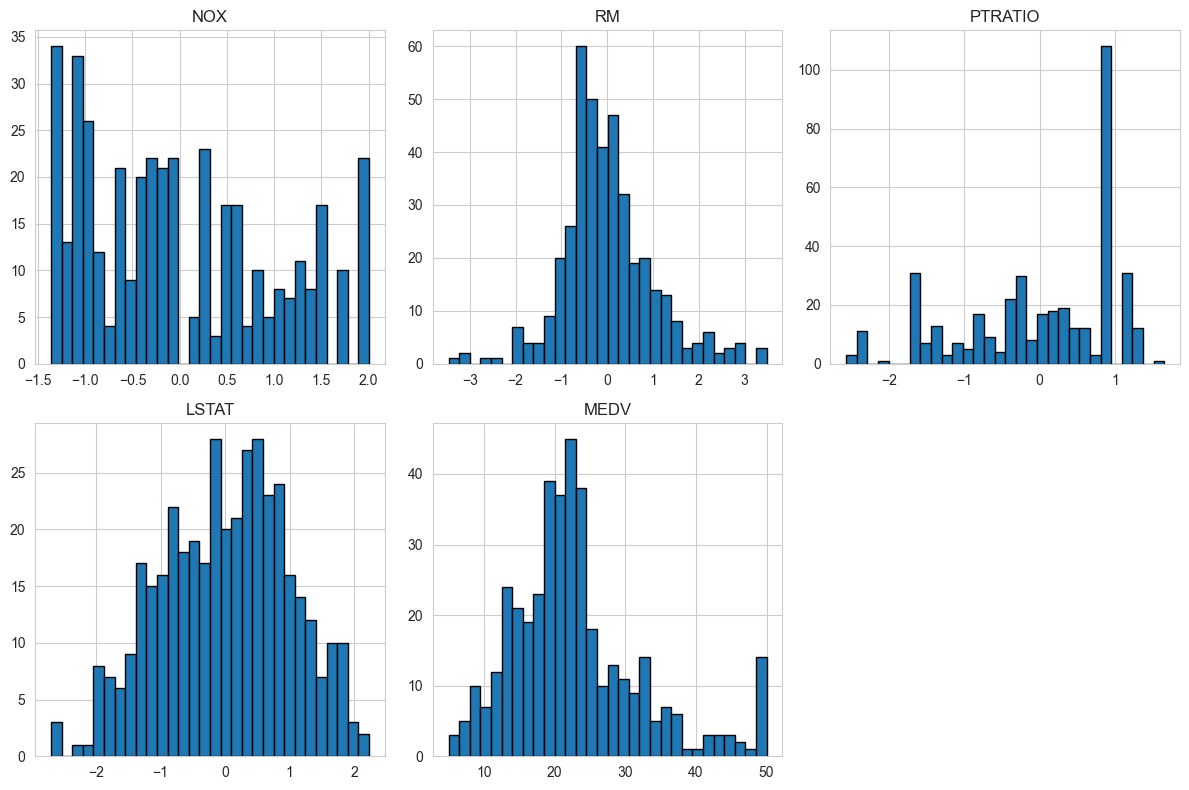

In [18]:
df_train.hist(bins=30, figsize=(12, 8), layout=(2, 3), edgecolor='black')
plt.tight_layout()
plt.show()

## Linear Regression (without framework)

### Linear regression functions

In [19]:
def h(x: np.ndarray, theta: np.ndarray, b: float) -> float:
    """
    Hypothesis function for linear regression.

    Predicts the median housing price in $1000s.

    Parameters:

    - x: Vector of feature values
    - theta: Vector of model parameters
    - b: Bias term

    Returns:
    - Predicted median housing price in $1000s
    """
    return np.dot(x, theta) + b

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the mean standard error of the predictions.

    Parameters:
    - y_true: Vector of true median housing prices in $1000s
    - y_pred: Vector of predicted median housing prices in $1000s

    Returns:
    - Standard error of the predictions
    """
    return float(np.mean((y_true - y_pred) ** 2))

def gradient_descent(X: np.ndarray, y: np.ndarray, theta: np.ndarray, b: float, learning_rate: float, epochs: int) -> Tuple[np.ndarray, float, list]:
    """
    Perform gradient descent to optimize the model parameters.

    Parameters:
    - X: Feature matrix
    - y: True median housing prices in $1000s
    - theta: Initial model parameters
    - b: Initial bias term
    - learning_rate: Learning rate for gradient descent
    - epochs: Number of iterations to run gradient descent
|
    Returns:
    - (theta, b, error): Tuple of optimized model parameters, bias term, and error history
    """
    m = len(y)
    error_history = []
    for _ in range(epochs):
        y_pred = h(X, theta, b)
        error = y_pred - y
        error_history.append(mse(y, y_pred))
        theta -= (learning_rate / m) * np.dot(X.T, error)
        b -= (learning_rate / m) * np.sum(error)
    return theta, b, error_history

### Model training

In [20]:
hypothesis_theta = np.random.randn(X_train.shape[1])
hypothesis_bias = np.random.randn()
learning_rate = 0.01
EPOCHS = 2000

theta, bias, error_history = gradient_descent(X_train.values, y_train.values, hypothesis_theta, hypothesis_bias, learning_rate, EPOCHS)

print("Optimized parameters (theta):", theta)
print("Optimized bias (b):", bias)
print("Last training error (MSE):", error_history[-1])

Optimized parameters (theta): [ 0.37045993  2.57647163 -1.64281925 -5.39108838]
Optimized bias (b): 22.79653461054175
Last training error (MSE): 23.049573668231258


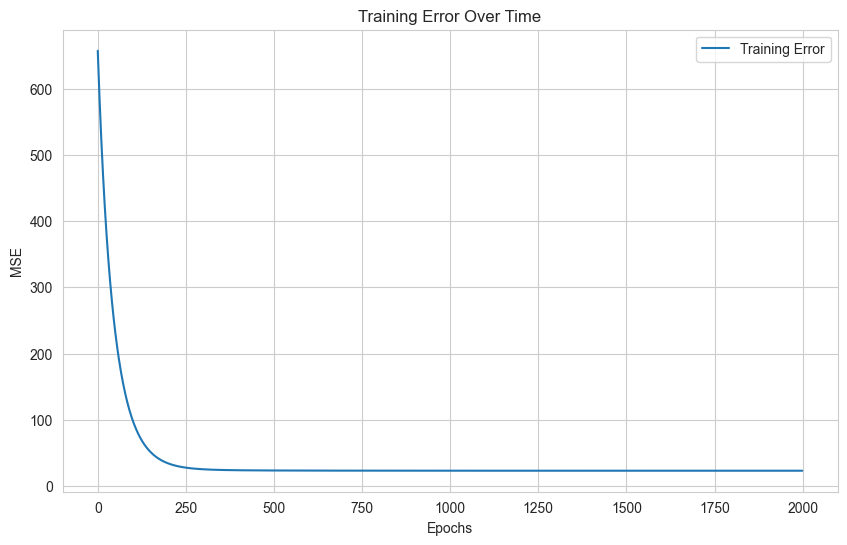

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), error_history, label="Training Error")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training Error Over Time")
plt.legend()
plt.show()

### Model testing

#### Prueba con test

In [22]:
y_train_pred_lr = h(X_train.values, theta, bias)
y_test_pred_lr = h(X_test.values, theta, bias)
test_error = mse(y_test.values, y_test_pred_lr)

print(f'Test Error: {test_error}')

Test Error: 22.074920080958695


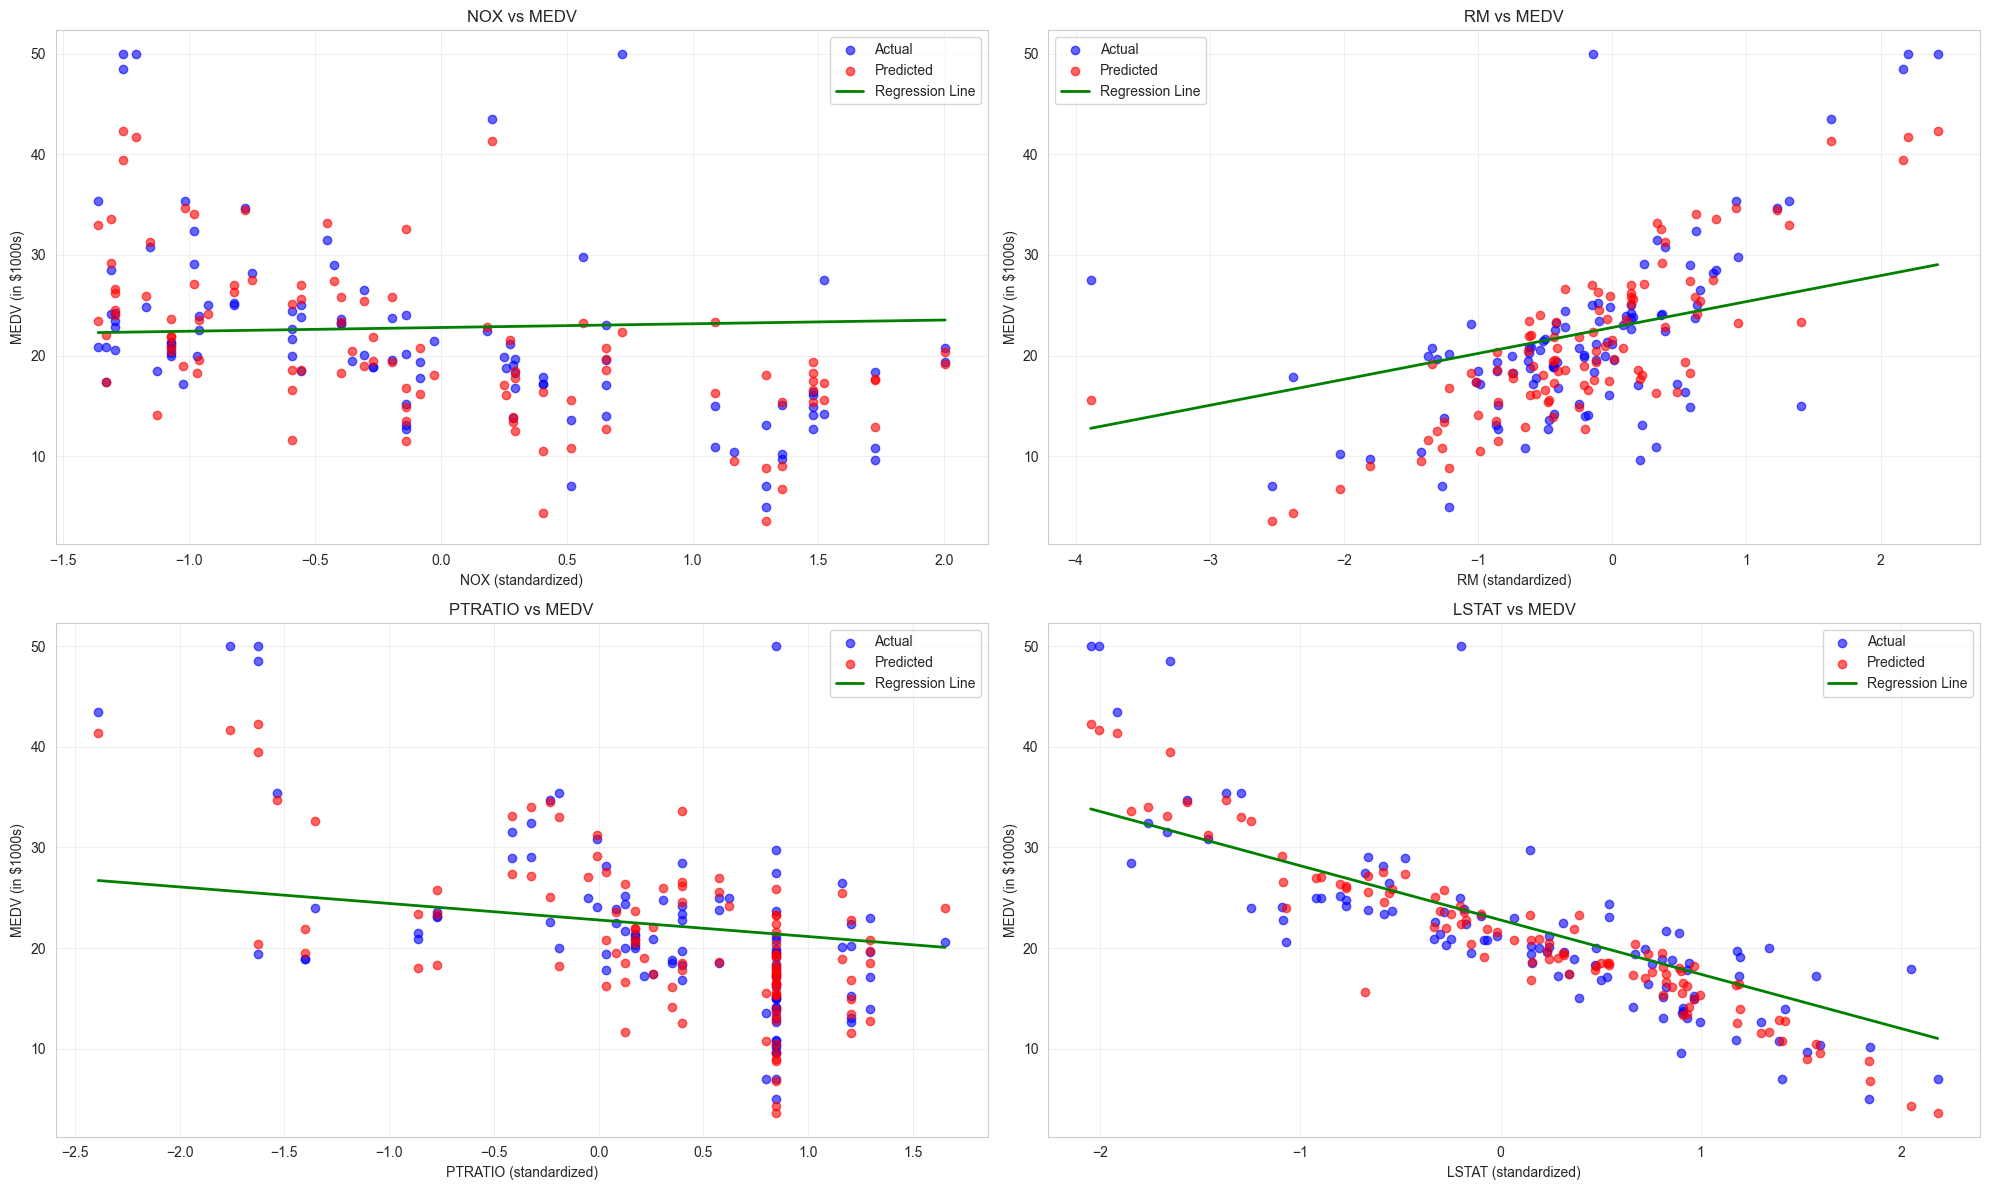

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

feature_names = ['NOX', 'RM', 'PTRATIO', 'LSTAT']

for i, feature_name in enumerate(feature_names):
    # Position
    row = i // 2
    col = i % 2

    # Scatter plot of actual values
    axes[row, col].scatter(X_test.iloc[:, i], y_test, alpha=0.6, color='blue', label='Actual')

    # Scatter plot of predicted values
    axes[row, col].scatter(X_test.iloc[:, i], y_test_pred_lr, alpha=0.6, color='red', label='Predicted')

    # Regression line
    x_range = np.linspace(X_test.iloc[:, i].min(), X_test.iloc[:, i].max(), 100)
    y_line = theta[i] * x_range + bias
    axes[row, col].plot(x_range, y_line, color='green', linewidth=2, label='Regression Line')

    axes[row, col].set_xlabel(f'{feature_name} (standardized)')
    axes[row, col].set_ylabel('MEDV (in $1000s)')
    axes[row, col].set_title(f'{feature_name} vs MEDV')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### $R^2$

In [24]:
r2_train_lr = r2_score(y_train, y_train_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

print(f'R² Train: {r2_train_lr}')
print(f'R² Test: {r2_test_lr}')
print(f'MSE: {mse(y_train, y_train_pred_lr)}')


R² Train: 0.7346763076748004
R² Test: 0.6989802089891052
MSE: 23.04957226981844


### Analysis of Outliers and Influential Points

In [25]:
# 1. OUTLIER IDENTIFICATION
def detect_outliers_comprehensive(X_train, y_train, X_test, y_test, model):
    """
    Identifies outliers using multiple methods
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Residuals
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # 1. Standardized Residuals
    std_residuals_train = residuals_train / np.std(residuals_train)
    std_residuals_test = residuals_test / np.std(residuals_test)

    # 2. Leverage (Hat values) - only for linear regression
    if hasattr(model, 'coef_'):  # It's linear regression
        X_train_with_intercept = np.column_stack([np.ones(len(X_train)), X_train])
        hat_matrix = X_train_with_intercept @ np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T
        leverage_train = np.diag(hat_matrix)

        X_test_with_intercept = np.column_stack([np.ones(len(X_test)), X_test])
        hat_matrix_test = X_test_with_intercept @ np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_test_with_intercept.T
        leverage_test = np.diag(hat_matrix_test[:len(X_test), :len(X_test)])
    else:
        leverage_train = np.zeros(len(X_train))
        leverage_test = np.zeros(len(X_test))

    # 3. Cook's Distance (only for linear regression)
    if hasattr(model, 'coef_'):
        p = X_train.shape[1]  # number of predictors
        cooks_d_train = (std_residuals_train**2 / p) * (leverage_train / (1 - leverage_train)**2)
        cooks_d_test = (std_residuals_test**2 / p) * (leverage_test / (1 - leverage_test)**2)
    else:
        cooks_d_train = np.zeros(len(X_train))
        cooks_d_test = np.zeros(len(X_test))

    # 4. DFFITS
    dffits_train = std_residuals_train * np.sqrt(leverage_train / (1 - leverage_train))
    dffits_test = std_residuals_test * np.sqrt(leverage_test / (1 - leverage_test))

    # Create DataFrames with results
    outliers_train = pd.DataFrame({
        'y_true': y_train,
        'y_pred': y_train_pred,
        'residual': residuals_train,
        'std_residual': std_residuals_train,
        'leverage': leverage_train,
        'cooks_d': cooks_d_train,
        'dffits': dffits_train
    })

    outliers_test = pd.DataFrame({
        'y_true': y_test.values if hasattr(y_test, 'values') else y_test,
        'y_pred': y_test_pred,
        'residual': residuals_test,
        'std_residual': std_residuals_test,
        'leverage': leverage_test,
        'cooks_d': cooks_d_test,
        'dffits': dffits_test
    })

    return outliers_train, outliers_test

# 2. OUTLIER VISUALIZATION
def plot_outlier_diagnostics(outliers_df, dataset_name='Test'):
    """
    Creates diagnostic plots for outliers
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Standardized Residuals
    axes[0,0].scatter(range(len(outliers_df)), outliers_df['std_residual'], alpha=0.6)
    axes[0,0].axhline(y=3, color='r', linestyle='--', label='±3σ')
    axes[0,0].axhline(y=-3, color='r', linestyle='--')
    axes[0,0].axhline(y=2, color='orange', linestyle=':', label='±2σ')
    axes[0,0].axhline(y=-2, color='orange', linestyle=':')
    axes[0,0].set_xlabel('Index')
    axes[0,0].set_ylabel('Standardized Residuals')
    axes[0,0].set_title(f'Standardized Residuals - {dataset_name}')
    axes[0,0].legend()

    # Mark extreme outliers
    extreme_outliers = outliers_df[np.abs(outliers_df['std_residual']) > 3]
    for idx in extreme_outliers.index:
        axes[0,0].annotate(f'{idx}',
                          (idx, outliers_df.loc[idx, 'std_residual']),
                          fontsize=8, color='red')

    # 2. Leverage vs Standardized Residuals
    axes[0,1].scatter(outliers_df['leverage'], outliers_df['std_residual'], alpha=0.6)
    axes[0,1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[0,1].set_xlabel('Leverage')
    axes[0,1].set_ylabel('Standardized Residuals')
    axes[0,1].set_title('Leverage vs Residuals')

    # Identify influential points
    high_leverage = outliers_df['leverage'] > 2 * outliers_df['leverage'].mean()
    high_residual = np.abs(outliers_df['std_residual']) > 2
    influential = high_leverage & high_residual

    if influential.any():
        influential_points = outliers_df[influential]
        axes[0,1].scatter(influential_points['leverage'],
                         influential_points['std_residual'],
                         color='red', s=100, label='Influential')
        for idx in influential_points.index:
            axes[0,1].annotate(f'{idx}',
                              (influential_points.loc[idx, 'leverage'],
                               influential_points.loc[idx, 'std_residual']),
                              fontsize=8, color='red')

    # 3. Cook's Distance
    axes[1,0].stem(range(len(outliers_df)), outliers_df['cooks_d'], basefmt=' ')
    axes[1,0].axhline(y=4/len(outliers_df), color='r', linestyle='--',
                      label=f'Threshold (4/n = {4/len(outliers_df):.3f})')
    axes[1,0].set_xlabel('Index')
    axes[1,0].set_ylabel("Cook's Distance")
    axes[1,0].set_title("Cook's Distance - Model Influence")
    axes[1,0].legend()

    # 4. Q-Q Plot of residuals
    stats.probplot(outliers_df['residual'], dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot of Residuals')

    plt.suptitle(f'Outlier Diagnostics - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return influential

# 3. IMPACT ANALYSIS
def analyze_outlier_impact(X_train, y_train, X_test, y_test, outlier_indices, model_class):
    """
    Evaluates the impact of removing outliers
    """
    # Model with all data
    model_full = model_class()
    model_full.fit(X_train, y_train)
    r2_full = model_full.score(X_test, y_test)
    rmse_full = np.sqrt(mean_squared_error(y_test, model_full.predict(X_test)))

    # Model without outliers
    mask = ~X_train.index.isin(outlier_indices)
    X_clean = X_train[mask]
    y_clean = y_train[mask]

    model_clean = model_class()
    model_clean.fit(X_clean, y_clean)
    r2_clean = model_clean.score(X_test, y_test)
    rmse_clean = np.sqrt(mean_squared_error(y_test, model_clean.predict(X_test)))

    # Comparison
    results = pd.DataFrame({
        'Model': ['With all data', 'Without outliers'],
        'N_train': [len(X_train), len(X_clean)],
        'R² Test': [r2_full, r2_clean],
        'RMSE Test': [rmse_full, rmse_clean],
        'ΔR²': [0, r2_clean - r2_full],
        'ΔRMSE': [0, rmse_clean - rmse_full]
    })

    return results, model_full, model_clean


MOST EXTREME OUTLIERS IN TEST SET (Linear Regression)
    y_true     y_pred   residual  std_residual   cooks_d
96    50.0  22.368301  27.631699      5.922622  0.074392
97    17.9   4.364204  13.535796      2.901284  0.041617
94    27.5  15.610315  11.889685      2.548454  0.249642


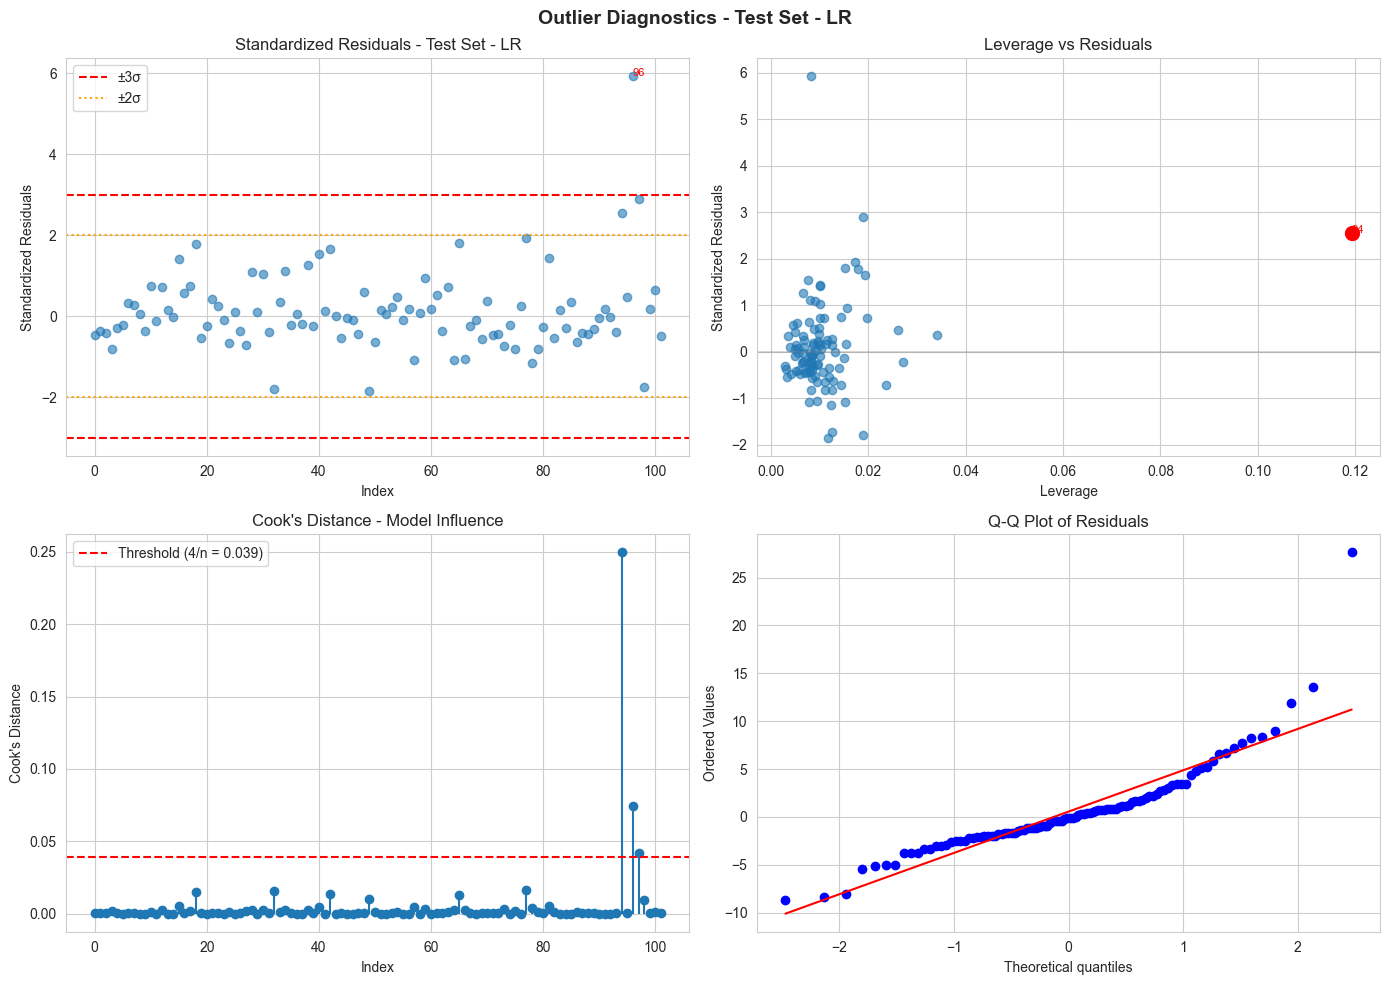


Outliers identified in training: 10

IMPACT OF REMOVING OUTLIERS:
           Model  N_train  R² Test  RMSE Test       ΔR²    ΔRMSE
   With all data      404 0.699094   4.697509  0.000000 0.000000
Without outliers      394 0.673188   4.895545 -0.025906 0.198036


In [26]:
lr_model = LinearRegression()
lr_model.coef_ = theta
lr_model.intercept_= bias

outliers_train_lr, outliers_test_lr = detect_outliers_comprehensive(
    X_train, y_train, X_test, y_test, lr_model
)

# Identify the most problematic cases
print("="*60)
print("MOST EXTREME OUTLIERS IN TEST SET (Linear Regression)")
print("="*60)

# Criteria for extreme outliers
extreme_criteria = (
    (np.abs(outliers_test_lr['std_residual']) > 3) |  # Residual > 3σ
    (outliers_test_lr['cooks_d'] > 4/len(outliers_test_lr)) |  # High Cook's D
    (np.abs(outliers_test_lr['dffits']) > 2*np.sqrt(4/len(outliers_test_lr)))  # High DFFITS
)

extreme_outliers = outliers_test_lr[extreme_criteria].sort_values('std_residual', ascending=False)
print(extreme_outliers[['y_true', 'y_pred', 'residual', 'std_residual', 'cooks_d']])

# Visualize diagnostics
influential_points = plot_outlier_diagnostics(outliers_test_lr, 'Test Set - LR')

# Analyze impact of removing outliers from training
outliers_train_indices = outliers_train_lr[
    np.abs(outliers_train_lr['std_residual']) > 2.5
].index

print(f"\nOutliers identified in training: {len(outliers_train_indices)}")

impact_results, model_with, model_without = analyze_outlier_impact(
    X_train, y_train, X_test, y_test,
    outliers_train_indices,
    LinearRegression
)

print("\nIMPACT OF REMOVING OUTLIERS:")
print(impact_results.to_string(index=False))


The analysis identified 3 extreme outliers in the test set, the most notable being a property valued at 50,000 that was predicted at only 22,388 (error of nearly 6 STD). However, contrary to intuition, removing the outliers from training resulted in a deterioration of the model:

* R² decreased from 0.699 to 0.673 (-3.7\%)
* RMSE increased from 4,698 to 4,896 (+4.2\%)

## Random Forest

In [27]:
# Reload data
df_rf = pd.read_csv("boston.csv")

# Drop categorical values
df_rf.drop(columns=["CHAS"], inplace=True)

df_rf.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [28]:
X_rf = df_rf.drop("MEDV", axis=1)
y_rf = df_rf["MEDV"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

df_train_rf = pd.concat([X_train_rf, y_train_rf], axis=1)
df_test_rf = pd.concat([X_test_rf, y_test_rf], axis=1)

print(f"Features para RF: {X_train.columns.tolist()}")
print(f"Número de features: {X_train.shape[1]}")

Features para RF: [0, 1, 2, 3]
Número de features: 4


In [29]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
)

rf.fit(X_train_rf, y_train_rf)

,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_train_pred_rf = rf.predict(X_train_rf)
y_test_pred_rf = rf.predict(X_test_rf)

r2_train_rf = r2_score(y_train_rf, y_train_pred_rf)
r2_test_rf = r2_score(y_test_rf, y_test_pred_rf)

print(f"\nRandom Forest Results:")
print(f"R² Train: {r2_train_rf}")
print(f"R² Test: {r2_test_rf}")
print(f"MSE Test: {mse(y_test_rf, y_test_pred_rf)}")


Random Forest Results:
R² Train: 0.903433955871483
R² Test: 0.820594650147442
MSE Test: 13.156473023889367


## Model Comparison

### Residuals Analysis

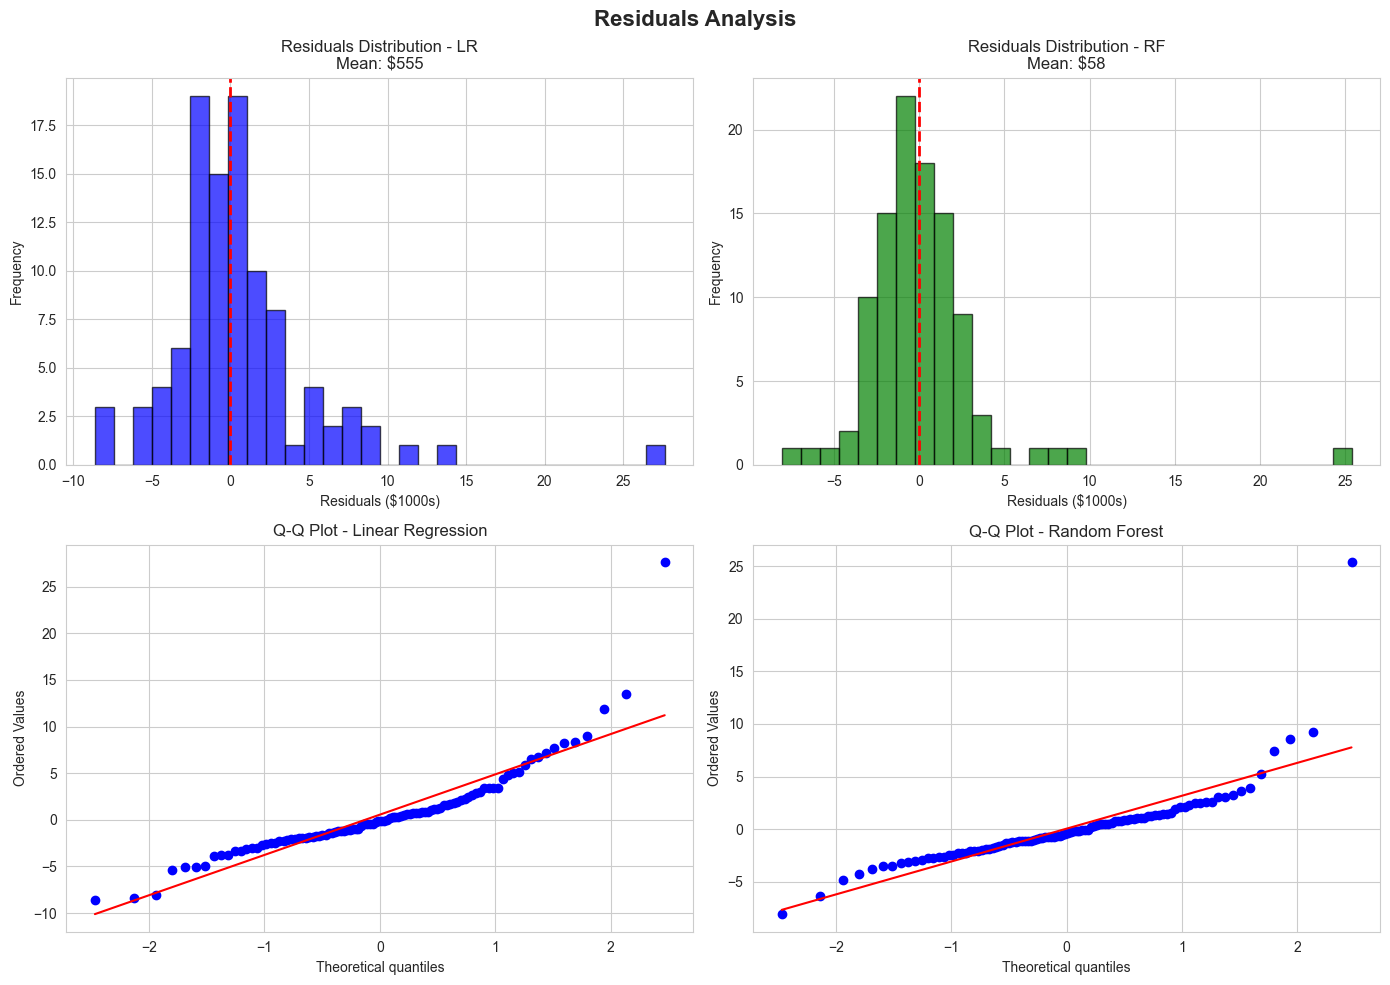

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# LR Residuals
residuals_lr = y_test - y_test_pred_lr
residuals_rf = y_test_rf - y_test_pred_rf

# Histograms
axes[0,0].hist(residuals_lr, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0,0].set_title(f'Residuals Distribution - LR\nMean: ${np.mean(residuals_lr)*1000:.0f}', fontsize=12)
axes[0,0].set_xlabel('Residuals ($1000s)')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(residuals_rf, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_title(f'Residuals Distribution - RF\nMean: ${np.mean(residuals_rf)*1000:.0f}', fontsize=12)
axes[0,1].set_xlabel('Residuals ($1000s)')
axes[0,1].set_ylabel('Frequency')

# Q-Q Plots
stats.probplot(residuals_lr, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot - Linear Regression', fontsize=12)

stats.probplot(residuals_rf, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot - Random Forest', fontsize=12)

plt.suptitle('Residuals Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Homoscedasticity

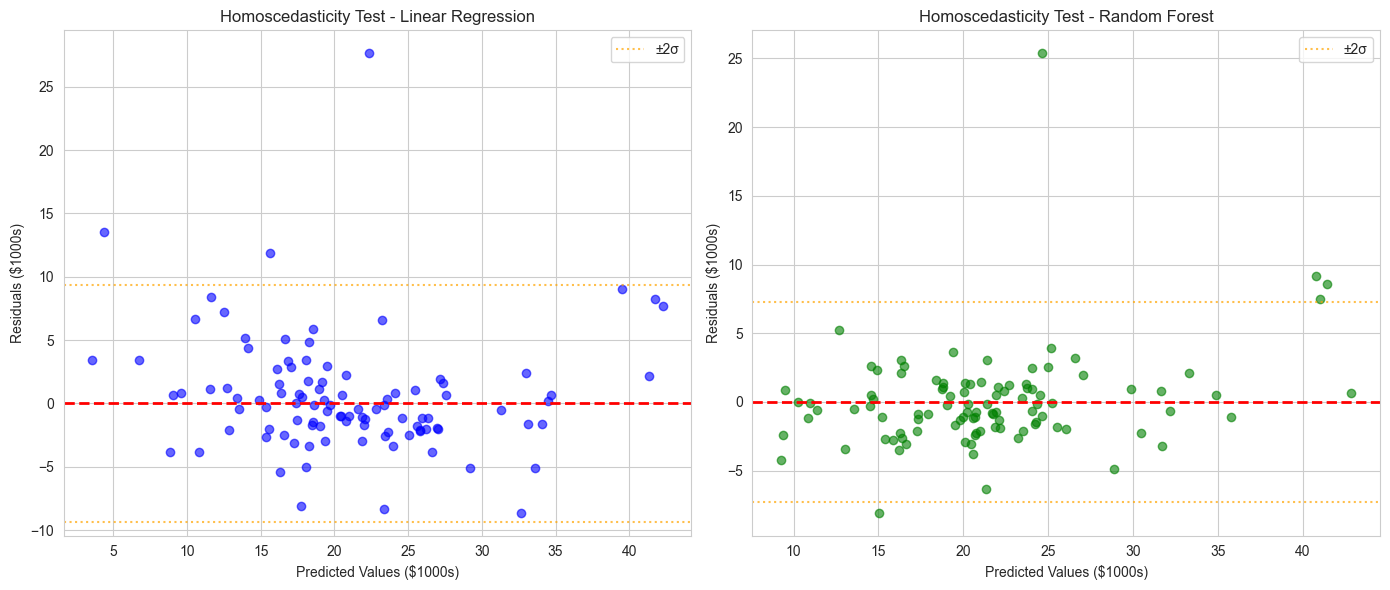

Breusch-Pagan Test for Heteroscedasticity:
Linear Regression p-value: 0.9841 (Homoscedastic)
Random Forest p-value: 0.2346 (Homoscedastic)


In [32]:
# Homoscedasticity Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression
axes[0].scatter(y_test_pred_lr, residuals_lr, alpha=0.6, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values ($1000s)')
axes[0].set_ylabel('Residuals ($1000s)')
axes[0].set_title('Homoscedasticity Test - Linear Regression')

# Add confidence bands
std_residuals_lr = stats.zscore(residuals_lr)
axes[0].axhline(y=2*np.std(residuals_lr), color='orange', linestyle=':', alpha=0.7, label='±2σ')
axes[0].axhline(y=-2*np.std(residuals_lr), color='orange', linestyle=':', alpha=0.7)
axes[0].legend()

# Random Forest
axes[1].scatter(y_test_pred_rf, residuals_rf, alpha=0.6, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values ($1000s)')
axes[1].set_ylabel('Residuals ($1000s)')
axes[1].set_title('Homoscedasticity Test - Random Forest')

# Add confidence bands
axes[1].axhline(y=2*np.std(residuals_rf), color='orange', linestyle=':', alpha=0.7, label='±2σ')
axes[1].axhline(y=-2*np.std(residuals_rf), color='orange', linestyle=':', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

# Breusch-Pagan statistical test
def breusch_pagan_test(y_true, y_pred):
    residuals = y_true - y_pred
    residuals_squared = residuals ** 2

    # Regression of squared residuals on predicted values
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred, residuals_squared)

    return p_value

bp_lr = breusch_pagan_test(y_test, y_test_pred_lr)
bp_rf = breusch_pagan_test(y_test_rf, y_test_pred_rf)

print(f"Breusch-Pagan Test for Heteroscedasticity:")
print(f"Linear Regression p-value: {bp_lr:.4f} {'(Heteroscedastic)' if bp_lr < 0.05 else '(Homoscedastic)'}")
print(f"Random Forest p-value: {bp_rf:.4f} {'(Heteroscedastic)' if bp_rf < 0.05 else '(Homoscedastic)'}")